### MAP556, Ecole Polytechnique, 2022-23

# TP 9 - Simulation de processus en temps continu et leur schéma d'Euler

L'objectif de cette séance est d'illustrer numériquement la simulation exacte de certain processus en temps continu (construits explicitement à partir du mouvement Brownien) ainsi que les résultats concernant la convergence du schéma d'Euler.

### Exercice 1. Simulation conjointe de processus de Ornstein-Uhlenbeck et de son schéma d'Euler

On considère dans cet exercise le processus $(X_t)_{t \ge 0}$ solution de l'équation différentielle stochastique

$$ dX_t = a(m - X_t) dt + \sigma \, dW_t, 
\qquad X_0 = x_0 \in \mathbb{R},
$$

où $a,m \in \mathbb{R}$, $\sigma > 0$, et $(W_t)_{t \ge 0}$ est un mouvement Brownien dans $\mathbb R$.

On considère un horizon de temps $T>0$ et un nombre $N\in{\mathbb N}^*$ de pas de discrétisation. 

On notera $t_k = T \frac k N$, $k \in \{0, \dots, N\}$.

1. Montrer que, pour tout $t \ge s$, le processus $X$ satisfait
$$
X_t = e^{-a(t-s)} X_s + m(1 - e^{-a(t-s)})
+ \sigma e^{-a t} \int_s^t e^{a u} dW_u.
$$
Quelle est la loi de la famille de variables aléatoires $\bigl(e^{-a t_{k+1}} \int_{t_k}^{t_{k+1}} e^{a u} dW_u \bigr)_{k = 0, \dots, N-1}$?

2. Ecrire le schéma d'Euler $(X^{(N)}_{t_k})_{k = 0, \dots, N-1}$ pour le processus $X$.


3. On souhaite simuler conjointement le processus $X$ et son schéma d'Euler $X^{(N)}$. Montrer que, pour tout $k$,
$$
\mathrm{Cov}
\Bigl(
e^{-a t_{k+1}} \int_{t_k}^{t_{k+1}} e^{a u} dW_u, \ 
W_{t_{k+1}} - W_{t_k}
\Bigr)
= 
\left(
\begin{array}{cc}
\frac 1{2a} (1 - e^{-2 a \frac T N}) &
\frac 1{a} (1 - e^{-a \frac T N})
\\
\frac 1{a} (1 - e^{-a \frac T N}) & \frac T N
\end{array}
\right) =: C.
$$
Quelle est la loi de la famille de vecteurs aléatoires
$
\biggl(
\begin{array}{c}
e^{-a t_{k+1}} \int_{t_k}^{t_{k+1}} e^{a u} dW_u
\\
W_{t_{k+1}} - W_{t_k}
\end{array}
\biggr)_{k = 0, \dots, N-1}$?


4. La fonction `numpy.linalg.cholesky(C)` renvoie une matrice triangulaire inférieure $L$ telle que $L \, L^T = C$.
Quelle est l'intérêt d'une telle fonction pour la simulation conjointe du processus $X$ et de son schéma d'Euler $X^{^{(N)}}$ sur la grille d'instants $(t_k)_{k=0,\dots,N}$?

5. En complétant le code ci-dessous, implémenter $M$ copies indépendantes de ces deux processus.
Tracer en fonction du pas de temps $\frac T N$ l'estimation empirique de l'erreur forte du schéma d'Euler
$$
\mathbb{E} \biggl[\max_{0\leq j \leq N} \bigl(X^{(N)}_{t_j} - X_{t_j}\bigr)^2 \biggr]^{1/2} 
$$

obtenue à partir d'une moyenne empirique sur les $M$ simulations. On pourra mettre à jour les vecteurs *Xe* (pour le schéma d'Euler) et *X* (pour le vrai processus) ainsi que le vecteur *max\_er* des $M$ copies de $\max_{0\leq j \leq k} (X^{(N)}_{t_j} - X_{t_j})^2$.

Que constatez-vous? Le résultat est-il conforme à la théorie?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
T = 1. 
sig = 0.8
a = 0.5 
m = 90.
x0 = 100.

In [2]:
def erreurForteEuler(T, sig, a, m, x0, N, M):
    """
    Estimation de l'erreur forte du schema d'Euler de pas h=T/N
    a partir d'un echantillon de M simulations.
    
    Output: le couple (erreur forte, demi-largeur de l'IC a 95%)
    """
    X = x0 * np.ones(M)
    Xe = x0 * np.ones(M)
    max_er = np.zeros(M)
    
    ########################
    # Parametres utiles pour
    # la discretisation
    ########################
    a_m_delta_T = a * m * T/N
    drift_X = m * (1 - np.exp(-a*T/N))

    ##########################################
    # Completer avec la matrice de covariance
    # de l'integrale stochastique et de l'increment
    # Brownien (voir Q3)
    ##########################################    
    C = np.array([[(1-np.exp(-2*a*T/N))/(2*a), (1-np.exp(-a*T/N))/a ],[(1-np.exp(-a*T/N))/a, T/N]])#np.identity(2) # modifier C
    
    L = np.linalg.cholesky(C)
    
    for k in range(N):
        g = np.random.randn(2,M)
        
        # Array de taille 2 x M
        increments_joints = np.dot(L,g)
        
        ##############################
        # Completer avec l'evolution du 
        # processus X
        ##############################
        X = X*np.exp(-a*T/N)+drift_X + sig*increments_joints[0,:] #modifier X
        
        ##############################
        # Completer avec l'evolution du 
        # processus Xe
        ##############################
        Xe = Xe + a*(m-Xe)*(T/N)+sig*increments_joints[1,:] #modifier Xe
        
        max_er = np.maximum(max_er, (X-Xe)**2)
    
    err_quadratique_eul = np.mean(max_er)
    
    err_eul = np.sqrt(err_quadratique_eul)
    
    ######################################
    # Completer avec l'IC pour err_eul
    # d'apres la methode delta
    ######################################
    variance_delta_methode = np.var(max_er)/(4*err_quadratique_eul) # modifier la variance

    largeur_IC_eul = 1.96 * np.sqrt(variance_delta_methode/M)
    
    return err_eul, largeur_IC_eul

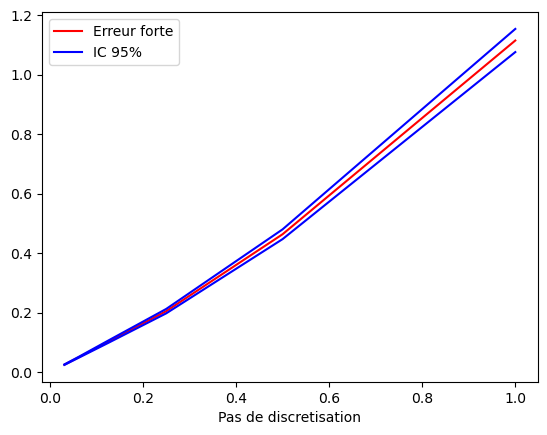

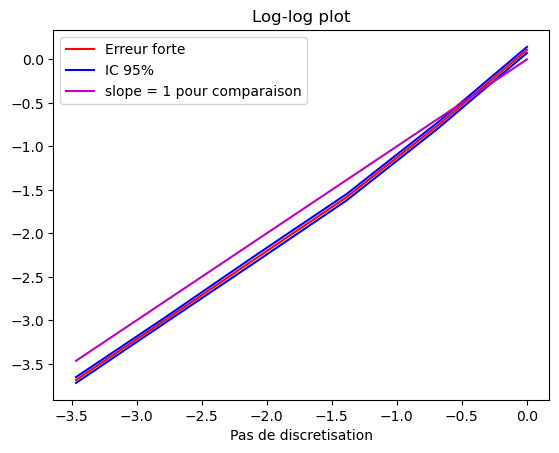

N:
[ 1.  2.  4.  8. 16. 32.]
Erreurs du schema d'Euler de pas N:
[1.11503239 0.463636   0.20504524 0.10183854 0.05033623 0.0250714 ]
IC a 95%:
[0.03892744 0.01643241 0.00743975 0.00391908 0.00156402 0.00083687]


In [3]:
##############################################################
# Partie 'main' du code: on applique la fonction erreurForteEuler
# pour différentes valeurs du pas de temps du schéma d'Euler
##############################################################

M = int(1.e2) # nombre de simulations independantes
N = 1 # nombre initial de pas de discretisation

P = 6 # le nombre de pas de temps est multiplié par 2 P fois dans la boucle ci-dessous

Npas = np.zeros(P) # on aura Npas = [1, 2, ... , 2^6]

err_eul = np.zeros(P) #pour stocker les erreurs du schema d'Euler
largeur_IC_eul = np.zeros(P) #pour stocker les largeurs des IC 

for i in range(P):
    Npas[i] = N
    
    err_eul[i], largeur_IC_eul[i] = erreurForteEuler(T, sig, a, m, x0, N, M)

    N = 2*N #multiplication du nombre N de pas par 2    

#######################################
# Representation graphique de l'erreur
# forte en fonction du pas h=T/N
#######################################
plt.clf()
plt.plot(T/Npas, err_eul, color="r", label="Erreur forte")
plt.plot(T/Npas, err_eul - largeur_IC_eul, color="b", label="IC 95%")
plt.plot(T/Npas, err_eul + largeur_IC_eul, color="b")
plt.xlabel('Pas de discretisation')
plt.legend(loc="best")
plt.show()

plt.clf()
plt.plot(np.log(T/Npas), np.log(err_eul), color="r", label="Erreur forte")
plt.plot(np.log(T/Npas), np.log(err_eul - largeur_IC_eul), color="b", label="IC 95%")
plt.plot(np.log(T/Npas), np.log(err_eul + largeur_IC_eul), color="b")
plt.plot(np.log(T/Npas),np.log(T/Npas), color="m", label="slope = 1 pour comparaison")
plt.xlabel('Pas de discretisation')
plt.legend(loc="best")
plt.title("Log-log plot")
plt.show()
#########################################
# On affiche les valeurs de l'erreur et
# de la largeur de l'IC
#########################################
print("N:"); print(Npas)
print("Erreurs du schema d'Euler de pas N:"); print(err_eul)
print("IC a 95%:"); print (largeur_IC_eul)

### Exercice 2.  Vitesse forte du schéma d'Euler pour une EDS linéaire

On cherche un processus $(S_t)_{t \ge 0}$ satisfaisant l'équation

$$
dS_t = r \, S_tdt + \sigma \, S_t dW_t,
\qquad S_0=s_0>0,
\qquad r,\sigma>0,
$$

où $(W_t)_{t \ge 0}$ est un mouvement Brownien à valeurs réelles.

1. Vérifier que le processus $S_t = s_0 e^{\sigma \, W_t + \left(r-\frac{\sigma^2}{2} \right)t}$, $t \ge 0$, satisfait l'équation ci-dessus. On admettra par la suite que ce processus est bien l'unique solution de l'EDS; c'est ce que l'on appelle un mouvement Brownien géométrique (MBG). 

La connaissance de la solution explicite permet d'estimer l'erreur forte du schéma d'Euler $S^{(h)}$ pour ce nouveau processus :

$$
\mathbb{E} \biggl[\max_{0\leq j \leq N}(S^{(h)}_{jh}-S_{jh})^2 \biggr]^{1/2} 
$$


On considère un horizon de temps $T>0$ et un nombre $N\in{\mathbb N}^*$ de pas de discrétisation.


2. Écrire l'évolution du schéma d'Euler $(S^{(h)}_{kh})_{0\leq k\leq N}$ de pas $h=\frac{T}{N}$.


3. Écrire l'évolution du vrai processus $(S_{kh})_{0\leq k\leq N}$ sur la même grille d'instants de discrétisation $\{k \, h\}_{0\leq k\leq N}$.

4. Dans le code ci-dessous, implémenter $M$ copies indépendantes de ces deux processus, en mettant à jour les vecteurs *Se* (pour le schéma d'Euler) et *S* (pour le vrai processus). Concrètement, il faudra mettre à jour le vecteur *max\_er* des $M$ copies de $\max_{0\leq j \leq k} (S^{(h)}_{jh} - S_{jh})^2$. On pourra calculer en dehors de la boucle sur l'indice temporel $k$ les paramètres utiles à la discrétisation, comme $\bigl(r-\frac{\sigma^2}{2}\bigr) \frac{T}{N}$.

In [4]:
T = 1. 
sig = 0.2
r = 0.02
S0 = 100

In [5]:
def erreurForteEuler(T, sig, r, S0, N, M):
    """
    Estimation de l'erreur forte du schema d'Euler de pas h=T/N
    a partir d'un echantillon de M simulations
    
    Output: le couple (erreur forte, demi-largeur de l'IC a 95%)
    """
    S = S0*np.ones(M)
    Se = S0*np.ones(M)
    max_er = np.zeros(M)
    
    ####################################################
    # Completer avec le calcul des parametres utiles
    # pour la discretisation, par exemple (r - 1/2*sigma^2)*T/N
    #
    ####################################################
    pas=T/N
    sqrtpas=np.sqrt(pas)
    # Dans la boucle ci-dessus, on fait évoluer un vecteur
    # de taille M
    for k in range(N):
        g = np.random.randn(M)
        #############################################
        # Completer avec l'evolution du processus S,
        # du schema d'Euler Se, et de l'ecart maximum
        # au carre max_er
        #############################################
        S = S*np.exp((r-sig**2/2)*pas+sig*sqrtpas*g)
        
        Se = Se*(1 + r*pas + sig*sqrtpas*g)
        
        ## Schéma alternatif: Question 5 - ne converge pas
        #Se=Se*(1+r*pas)/(1-sig*sqrtpas*g)
        
        ## Correction du schéma alternatif
        #Se=Se*(1+(r-sig**2)*pas)/(1-sig*sqrtpas*g)
        
        max_er = np.maximum(max_er,(S-Se)**2)
    
    err_quadratique_eul = np.sum(max_er) / M
    
    err_eul = np.sqrt(err_quadratique_eul)
    
    #############################################
    # Completer avec le calcul de la demi-largeur 
    # de l'IC a 95% d'apres la methode delta
    #############################################
    variance_delta_methode = np.var(max_er)/(4*err_quadratique_eul)

    largeur_IC_eul = 1.96 * np.sqrt(variance_delta_methode / M)
    
    return err_eul, largeur_IC_eul


4. La cellule ci-dessous trace en fonction de $h$ l'estimation empirique de
$$
\mathbb{E} \biggl[\max_{0\leq j \leq N}(S^{(h)}_{jh}-S_{jh})^2 \biggr]^{1/2} 
$$

à partir des $M$ trajectoires simulées, ainsi que les bornes de l'intervalle de confiance à 95% basé sur le théorème de la limite centrale. Que constatez-vous? 

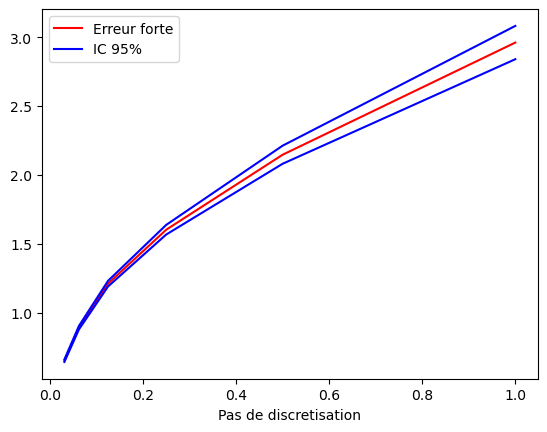

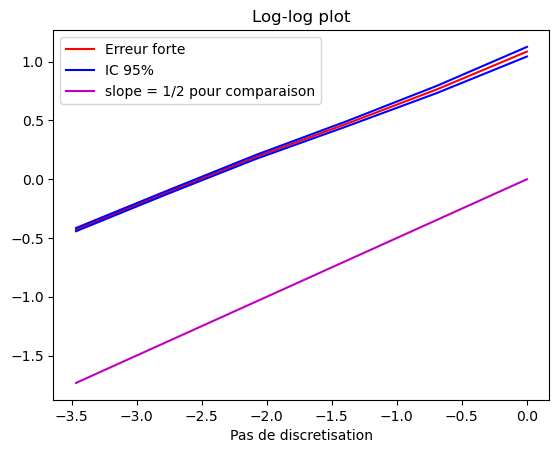

N:
[ 1.  2.  4.  8. 16. 32.]
Erreurs du schema d'Euler de pas N:
[2.96113882 2.14662669 1.60243563 1.21081602 0.89132574 0.65145469]
IC a 95%:
[0.12083403 0.06564305 0.03496953 0.02049107 0.01267915 0.00885564]


In [6]:
M = int(1.e4) #nombre de simulations independantes
N = 1 #nombre initial de pas de discretisation

## On considère la suite de nombres de pas N = 1, 2, 4, ..., 2^P
P = 6

Npas = np.zeros(P)

err_eul = np.zeros(P) # pour stocker les erreurs du schema d'Euler
largeur_IC_eul = np.zeros(P) # pour stocker les largeurs des IC 

for i in range(P):
    Npas[i] = N
    
    err_eul[i], largeur_IC_eul[i] = erreurForteEuler(T, sig, r, S0, N, M)

    N = 2*N #multiplication du nombre N de pas par 2    

############################################################
# Completer avec l'affichage de l'erreur et de son
# intervalle de confiance en fonction du pas de discretisation h
############################################################
plt.clf()
plt.plot( T/Npas , err_eul , color="r", label="Erreur forte")
plt.plot( T/Npas , err_eul+largeur_IC_eul , color="b", label="IC 95%")
plt.plot( T/Npas , err_eul-largeur_IC_eul, color="b")

plt.xlabel('Pas de discretisation')
plt.legend(loc="best")
plt.show()

plt.clf()
plt.plot( np.log(T/Npas) , np.log(err_eul) , color="r", label="Erreur forte")
plt.plot( np.log(T/Npas) , np.log(err_eul+largeur_IC_eul) , color="b", label="IC 95%")
plt.plot( np.log(T/Npas) , np.log(err_eul-largeur_IC_eul), color="b")
plt.plot(np.log(T/Npas), 0.5*np.log(T/Npas), color="m", label="slope = 1/2 pour comparaison")

plt.xlabel('Pas de discretisation')
plt.legend(loc="best")
plt.title('Log-log plot')

plt.show()

#########################################
# On affiche les valeurs de l'erreur et
# de la largeur de l'IC
#########################################
print("N:"); print(Npas)
print("Erreurs du schema d'Euler de pas N:"); print(err_eul)
print("IC a 95%:"); print (largeur_IC_eul)

5. Implémenter un schéma alternatif $(\tilde S^{(h)}_{kh})_{0\leq k\leq N}$ où l'on remplaçe l'intégrale stochastique par son approximation $\sigma \tilde S^{(h)}_{(k+1)h} (W_{(k+1)h} - W_{kh})$ au lieu de $\sigma \tilde S^{(h)}_{kh} (W_{(k+1)h} - W_{kh})$. 
Tracer l'estimation empirique de l'erreur pour ce nouveau schéma. Qu'observez-vous?


__Réponse__: voir cellule de code ci-dessus (decommenter la ligne "schéma alternatif")